In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from keras.models import load_model

Using TensorFlow backend.


# Load Data

In [2]:
element_list = ['H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'Ar', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr','Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'I', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Ac', 'Th', 'Pa', 'U', 'Np', 'Pu']
df_test = pd.read_csv('../Data/oqmd_test.csv')

## Convert string representation of molecular formula to one-hot encoding

In [3]:
def counts2vector(pairs):
    vec = [0]*len(element_list)
    for pair in pairs:
        vec[element_list.index(pair[0])]+=int(pair[1])
    vec = np.array(vec)
    return vec

def onehot(enc):
    rep = np.zeros((len(element_list),11))
    rep[:,0] = 1
    for i,val in enumerate(enc):
        if val!=0:
            rep[i][0]=0
            rep[i][val]=1
    return rep.flatten()

def encode(df):
    formulae = df[['comp']]
    counts = pd.Series(formulae.values.flatten()).str.findall(r"([a-z]+)([0-9]+)", re.I)
    df['encoding'] = counts.apply(counts2vector)
    df['onehot'] = df['encoding'].apply(onehot)

In [4]:
encode(df_test)

## Extract the encoding and target values

In [5]:
X_test = df_test.onehot.values
X_test = np.stack(X_test,axis=0)
y_test = df_test[['delta_e','volume_pa','energy_pa']].values

# Load Predictor Models

In [6]:
pred_delta_e = load_model('delta_e_best_model.h5')
pred_energy_pa = load_model('energy_pa_best_model.h5')
pred_volume_pa =load_model('volume_pa_best_model.h5')

# Predict properties of Test Set

In [7]:
y_pred_delta_e = pred_delta_e.predict(X_test)
error_deltae = np.abs(y_pred_delta_e.flatten() - y_test[:,0])
y_pred_volume = pred_volume_pa.predict(X_test)
error_volume = np.abs(y_pred_volume.flatten() - y_test[:,1])
y_pred_energy = pred_energy_pa.predict(X_test)
error_energy = np.abs(y_pred_energy.flatten() - y_test[:,2])

In [8]:
delta_e_mae = 0.05149281776189898
volume_pa_mae = 0.3985822759482463
energy_pa_mae = 0.07218225800914231

# Plot Mean Absolute Error vs Ground Truth for different error thresholds

In [9]:
def plot_all(idx, error, mae, name, color='b', xlims=None):
    fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2,2,figsize=(80, 40))
    x_data = y_test[:,idx]
    ax1.scatter(x_data, error, s=100, c=color)

    ax2.scatter(x_data, error, s=100, c=color)
    if xlims:
        ax2.set_xlim(xlims)
    ax2.set_ylim(0,5)

    ax3.scatter(x_data, error, s=100, c=color)
    if xlims:
        ax3.set_xlim(xlims)
    ax3.set_ylim(0,1)

    ax4.scatter(x_data, error, s=100, c=color)
    if xlims:
        ax4.set_xlim(xlims)
    ax4.set_ylim(0, mae)
    fig.text(0.5, 0, name, ha='center')
    fig.text(0.07, 0.3, 'Mean Absolute Error', ha='center', rotation='vertical')
    plt.show()

## Set plot parameters

In [10]:
plt.rc('xtick', labelsize=70)
plt.rc('xtick.major', size=50, width=6, pad=30)
plt.rc('ytick.major', size=50, width=6, pad=30)
plt.rc('ytick', labelsize=70)
plt.rc('axes',linewidth=10)
plt.rc('font', size=130)

## Formation Enthalpy

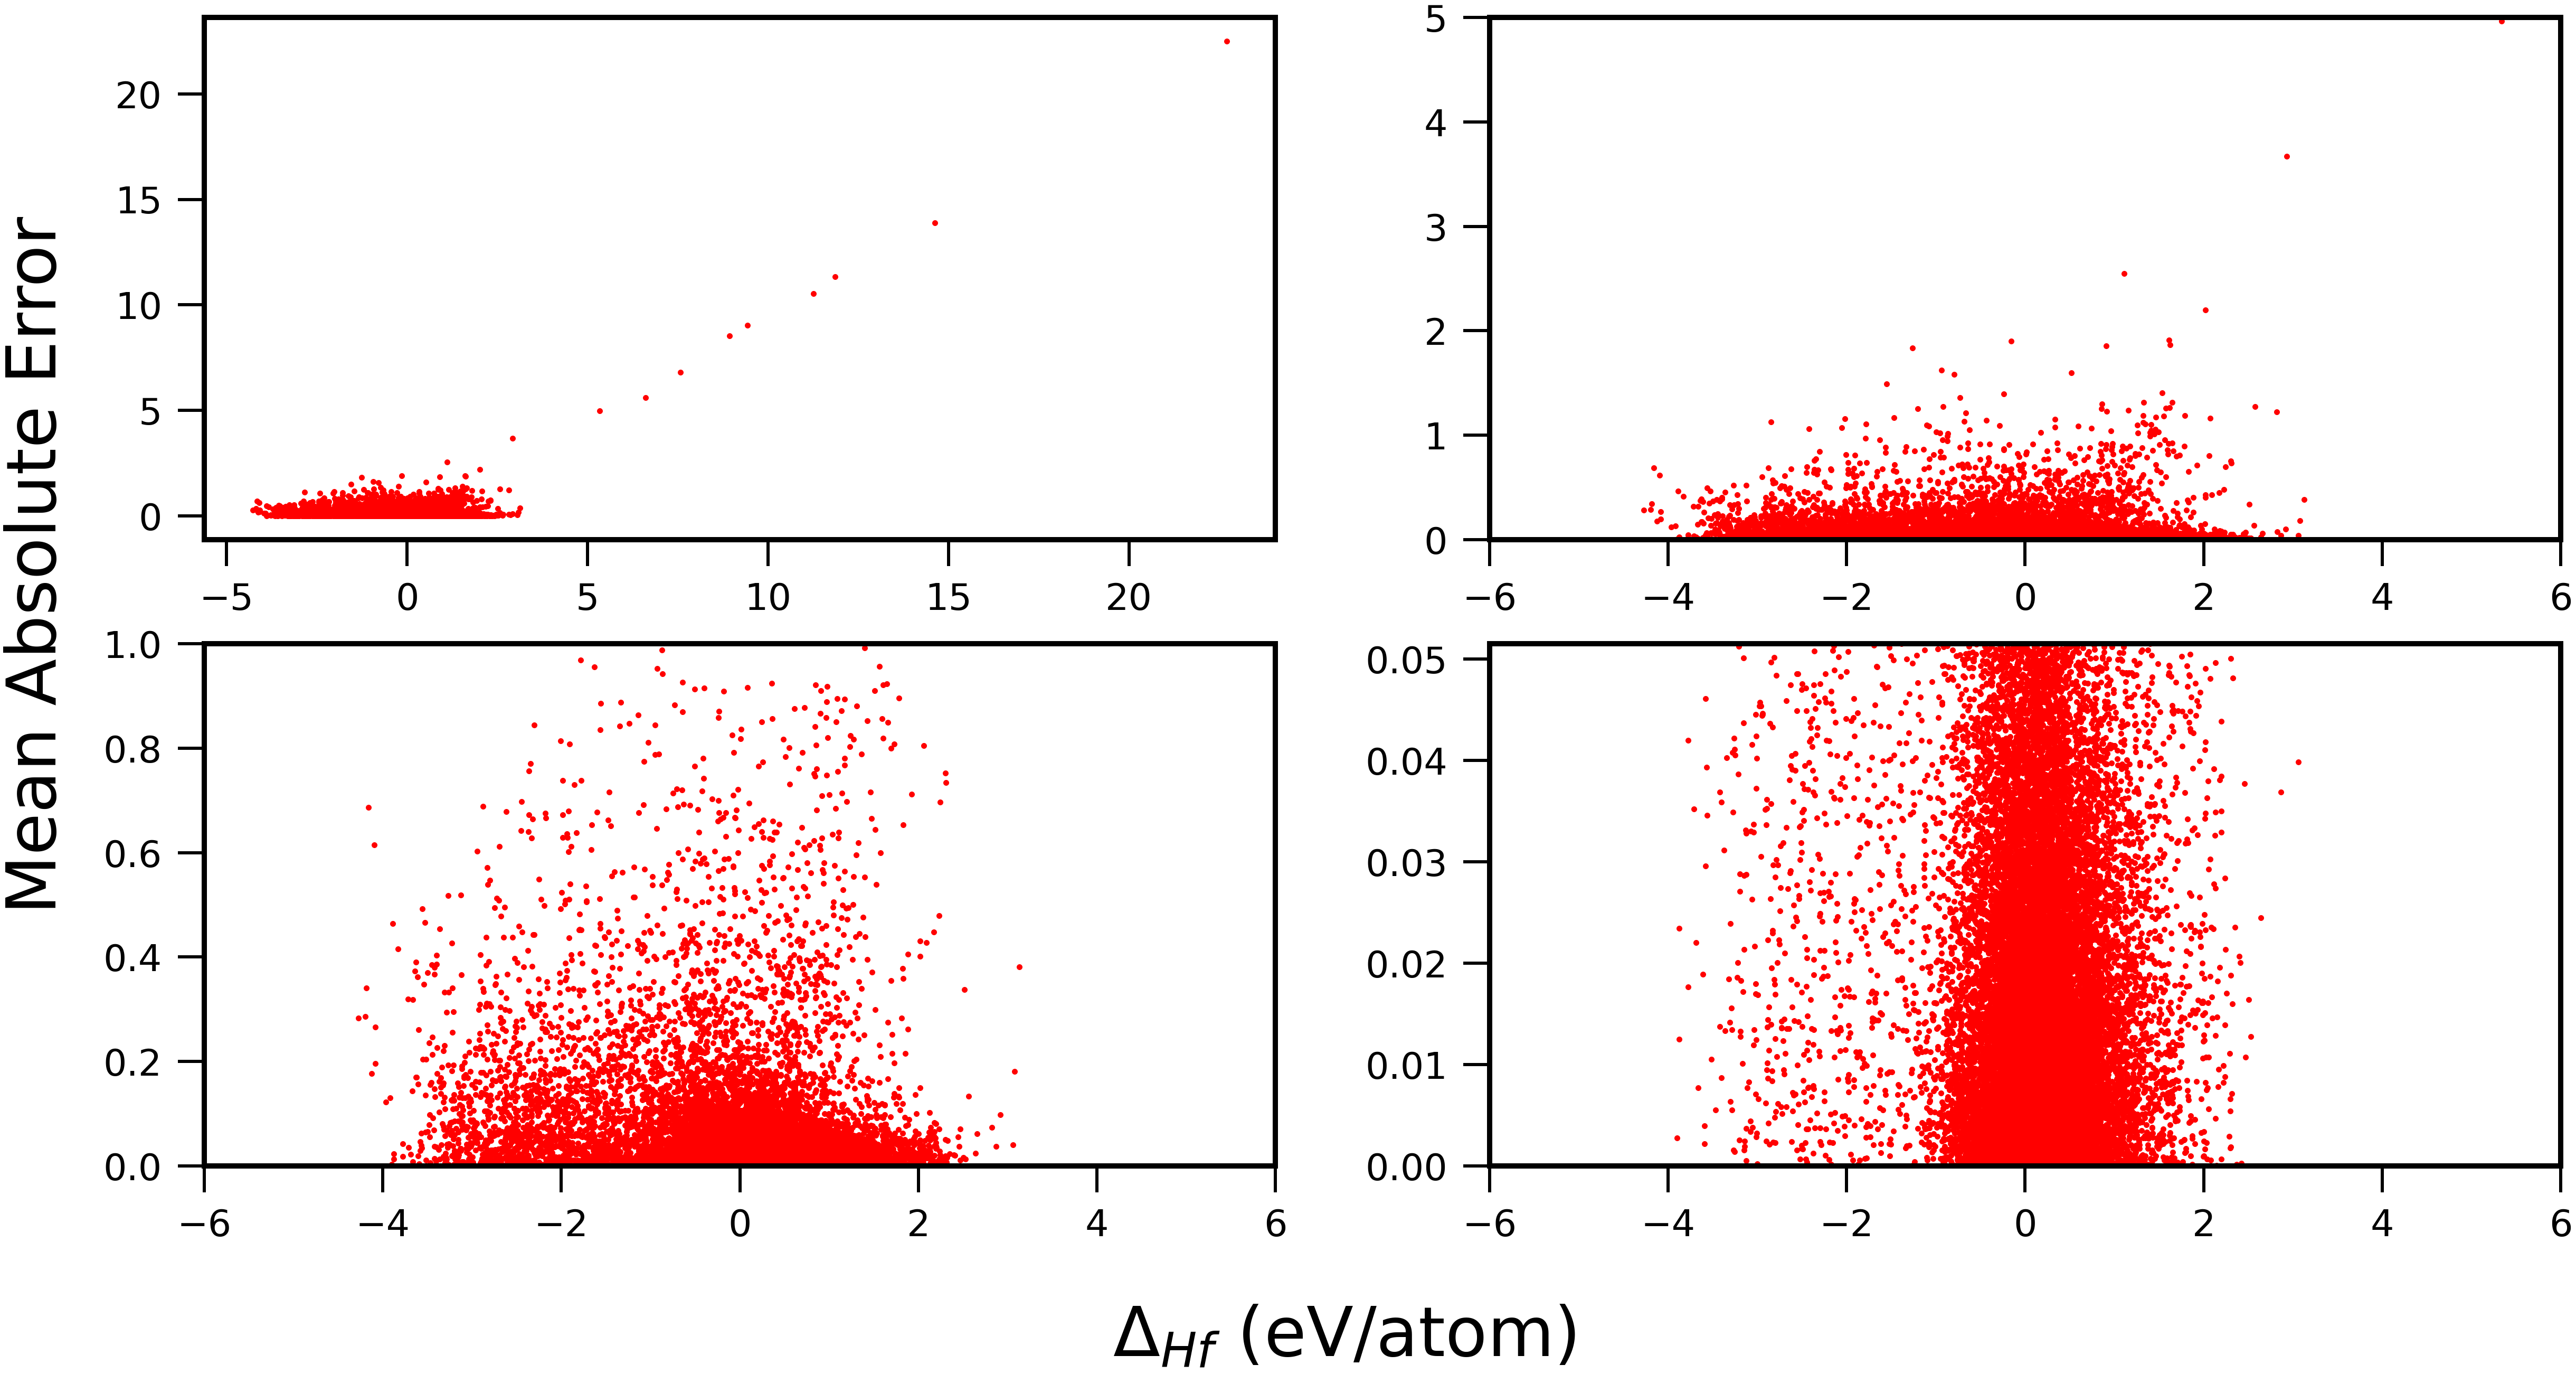

In [11]:
plot_all(0, error_deltae, delta_e_mae, r'$\Delta_{Hf}$ (eV/atom)', 'r', (-6, 6))

## Volume per Atom

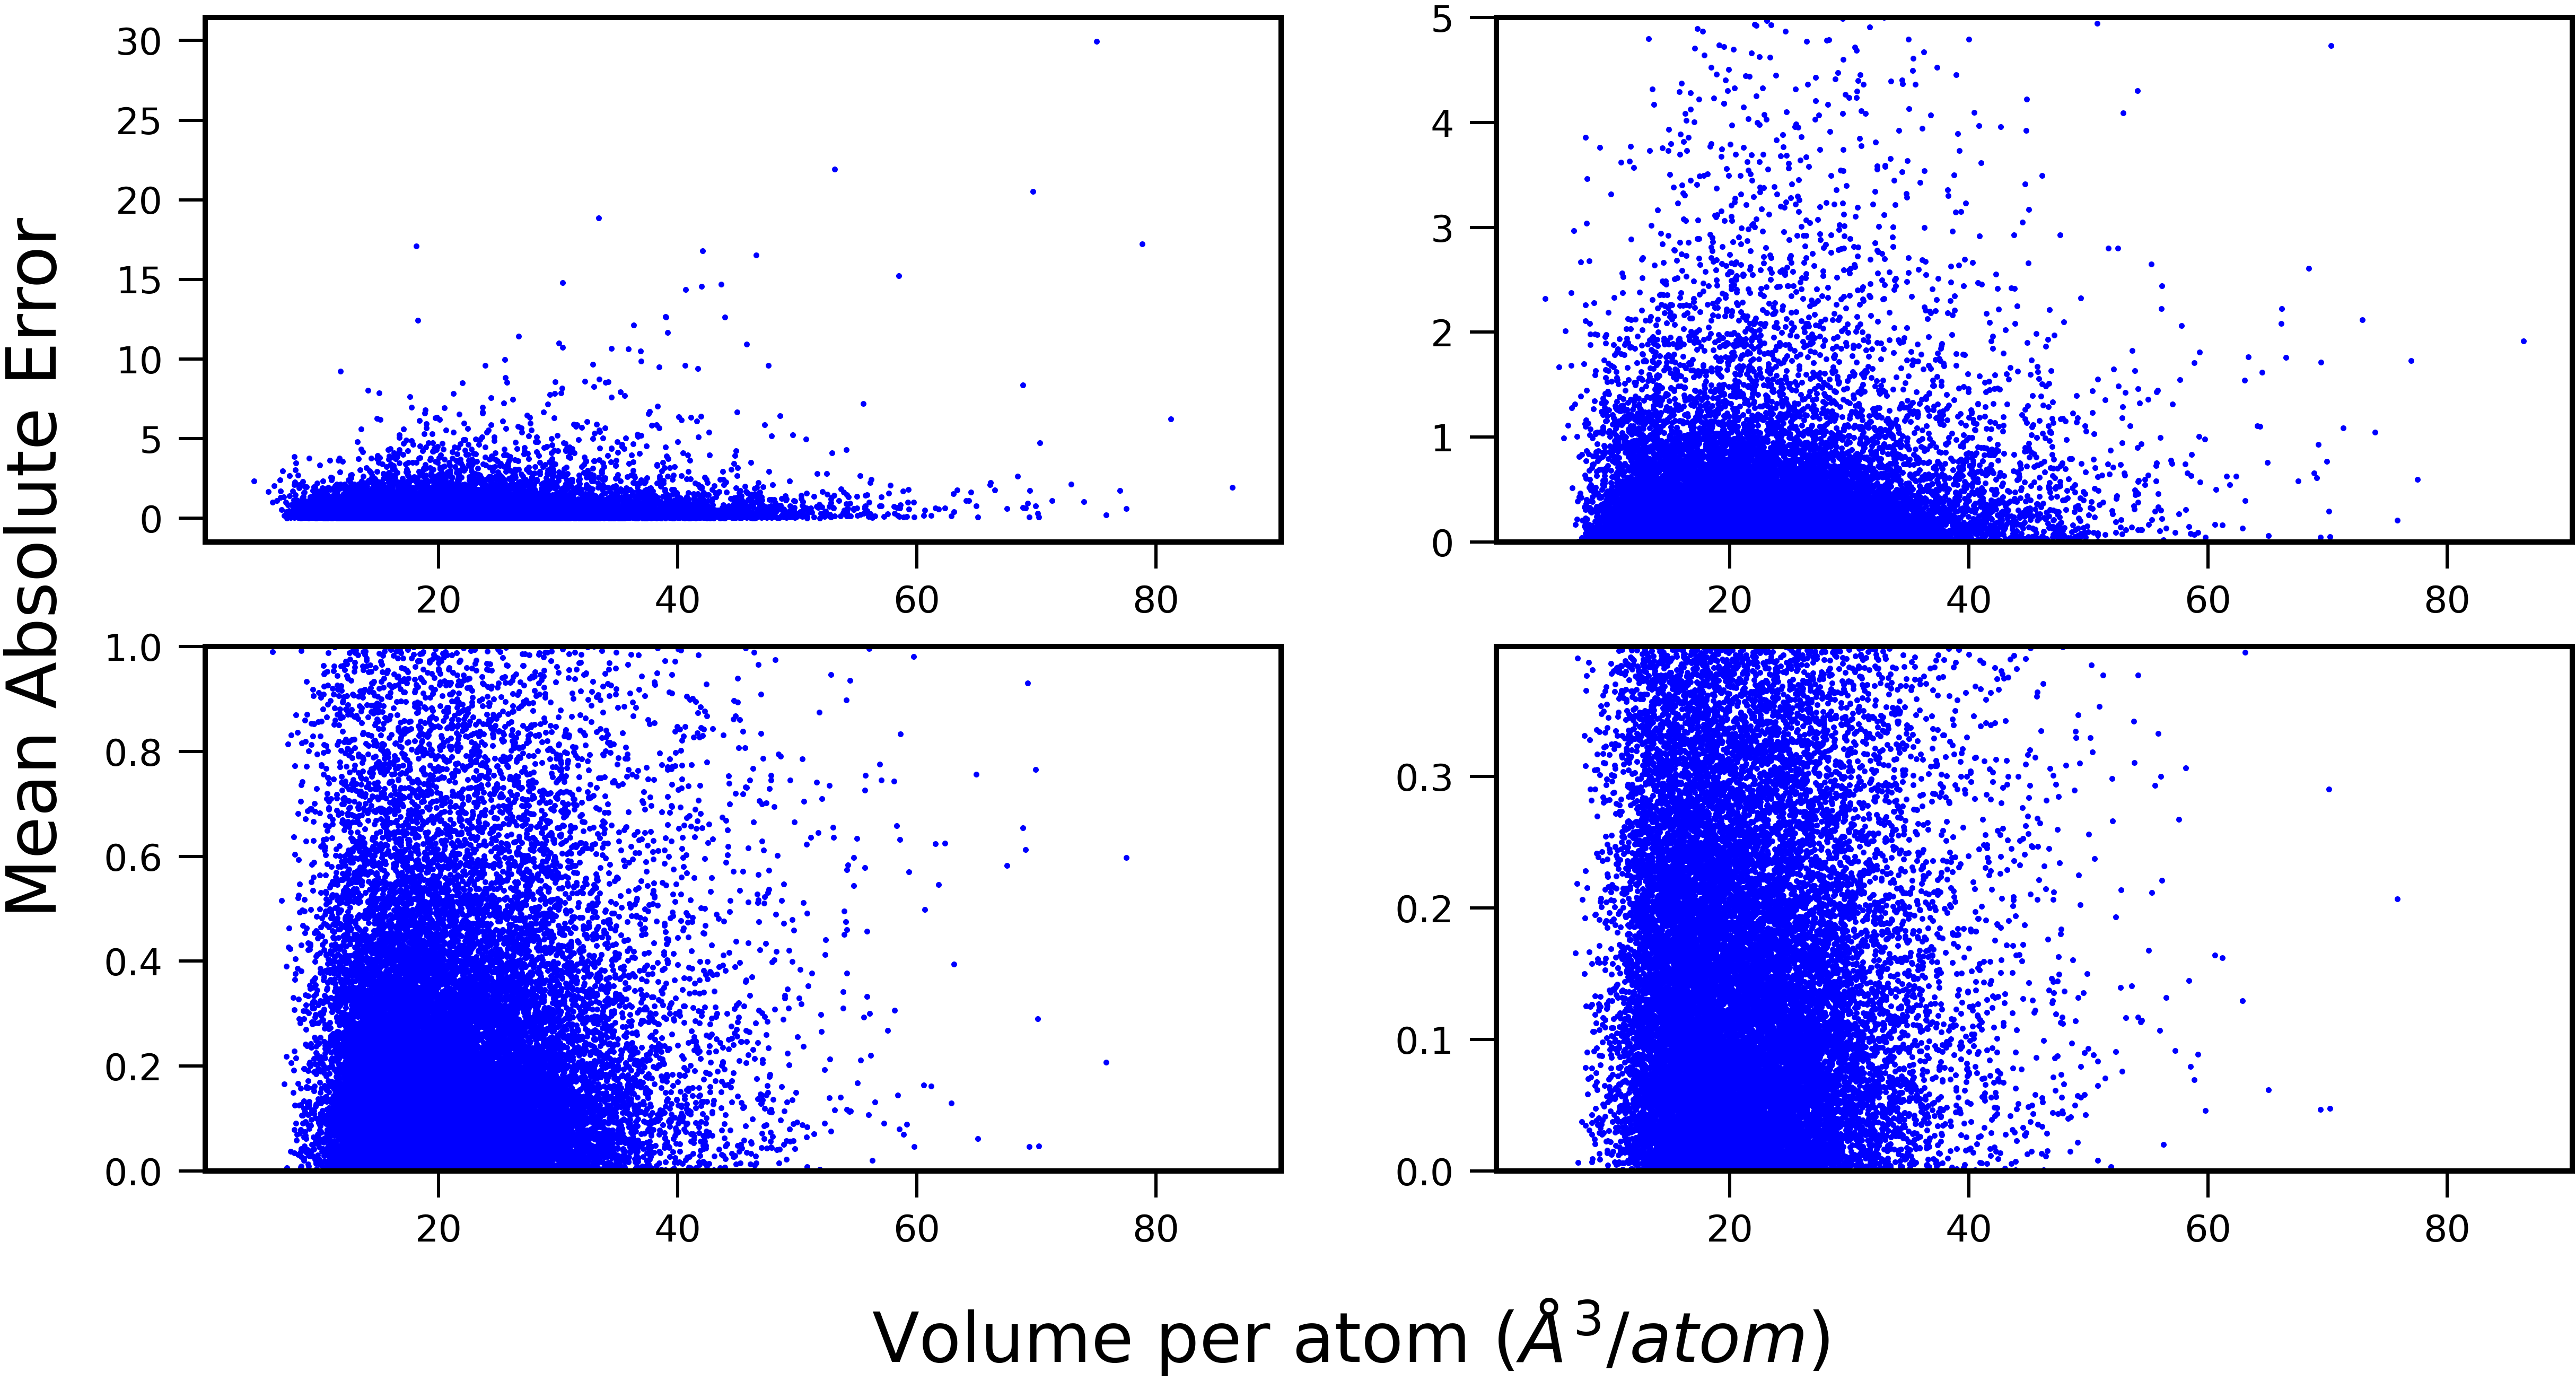

In [12]:
plot_all(1, error_volume, volume_pa_mae, r'Volume per atom $(\AA^3/atom)$')

## Energy per Atom

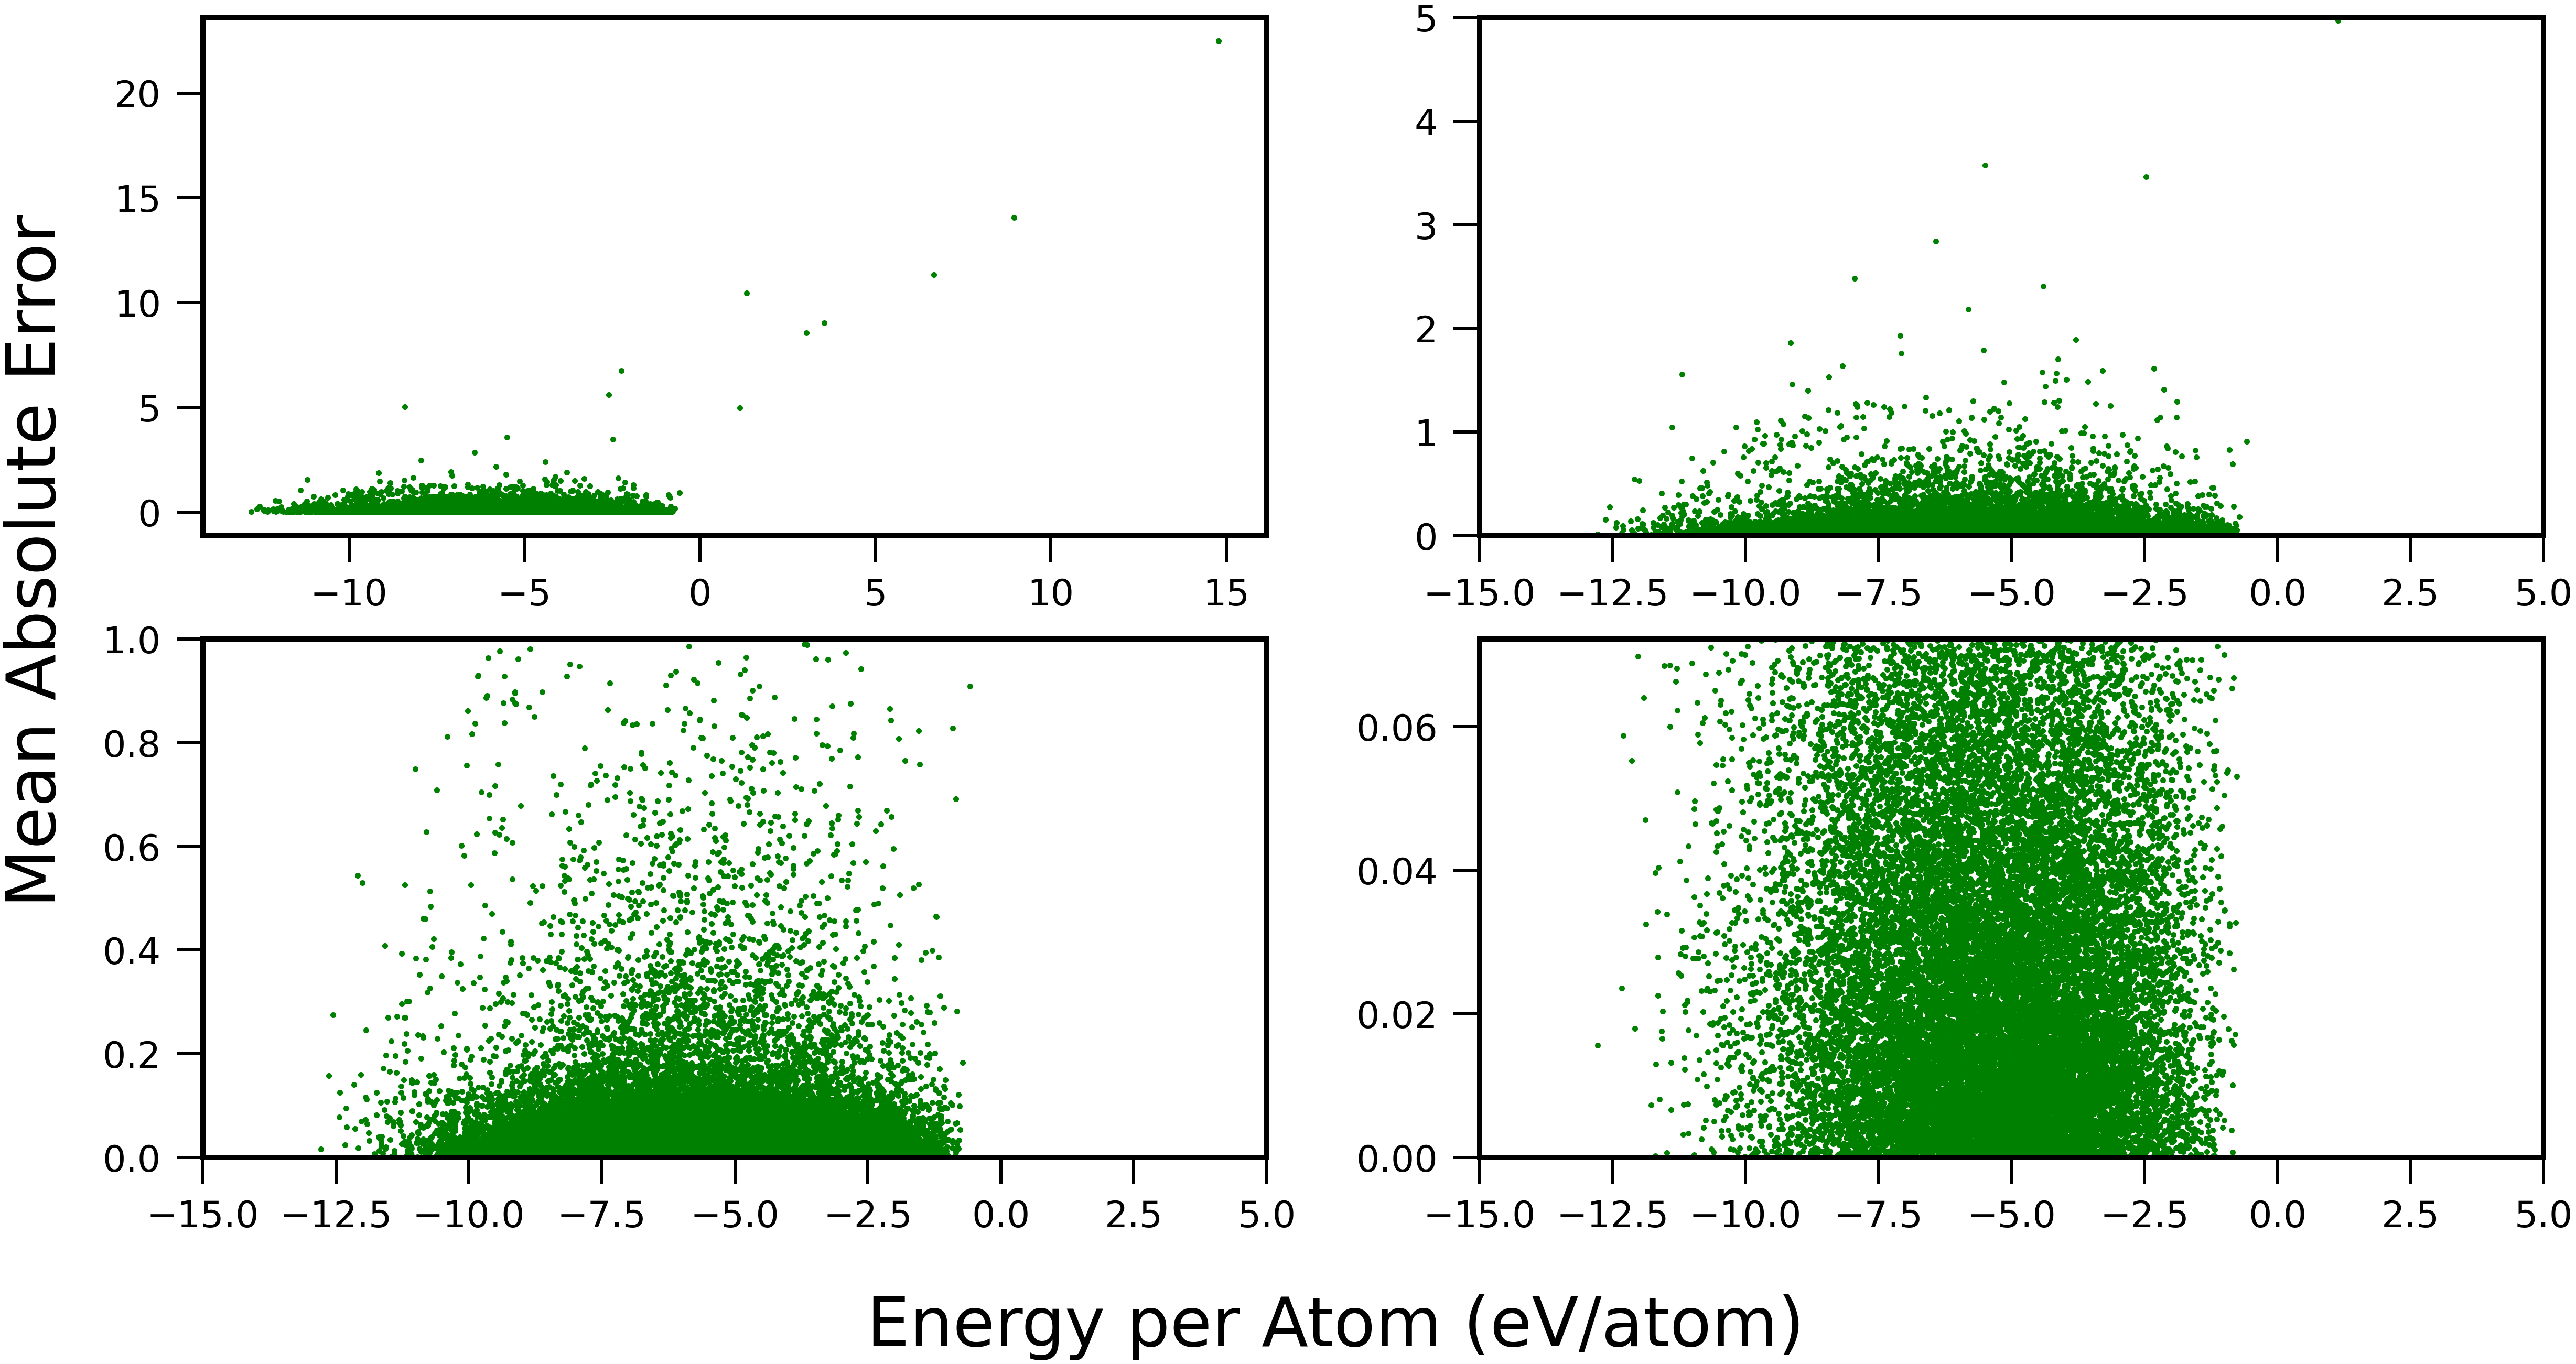

In [13]:
plot_all(2, error_energy, energy_pa_mae, 'Energy per Atom (eV/atom)', 'g', (-15, 5))

# Applicability Range

In [9]:
plt.rc('xtick', labelsize=70)
plt.rc('xtick.major', size=40, width=6, pad=30)
plt.rc('xtick.minor', size=40, width=6, pad=30)
plt.rc('ytick.major', size=40, width=6, pad=30)
plt.rc('ytick', labelsize=70)
plt.rc('axes',linewidth=6, labelsize=60, labelpad=30)

-3.90055577562
3.05839856375
0.04797139760528212


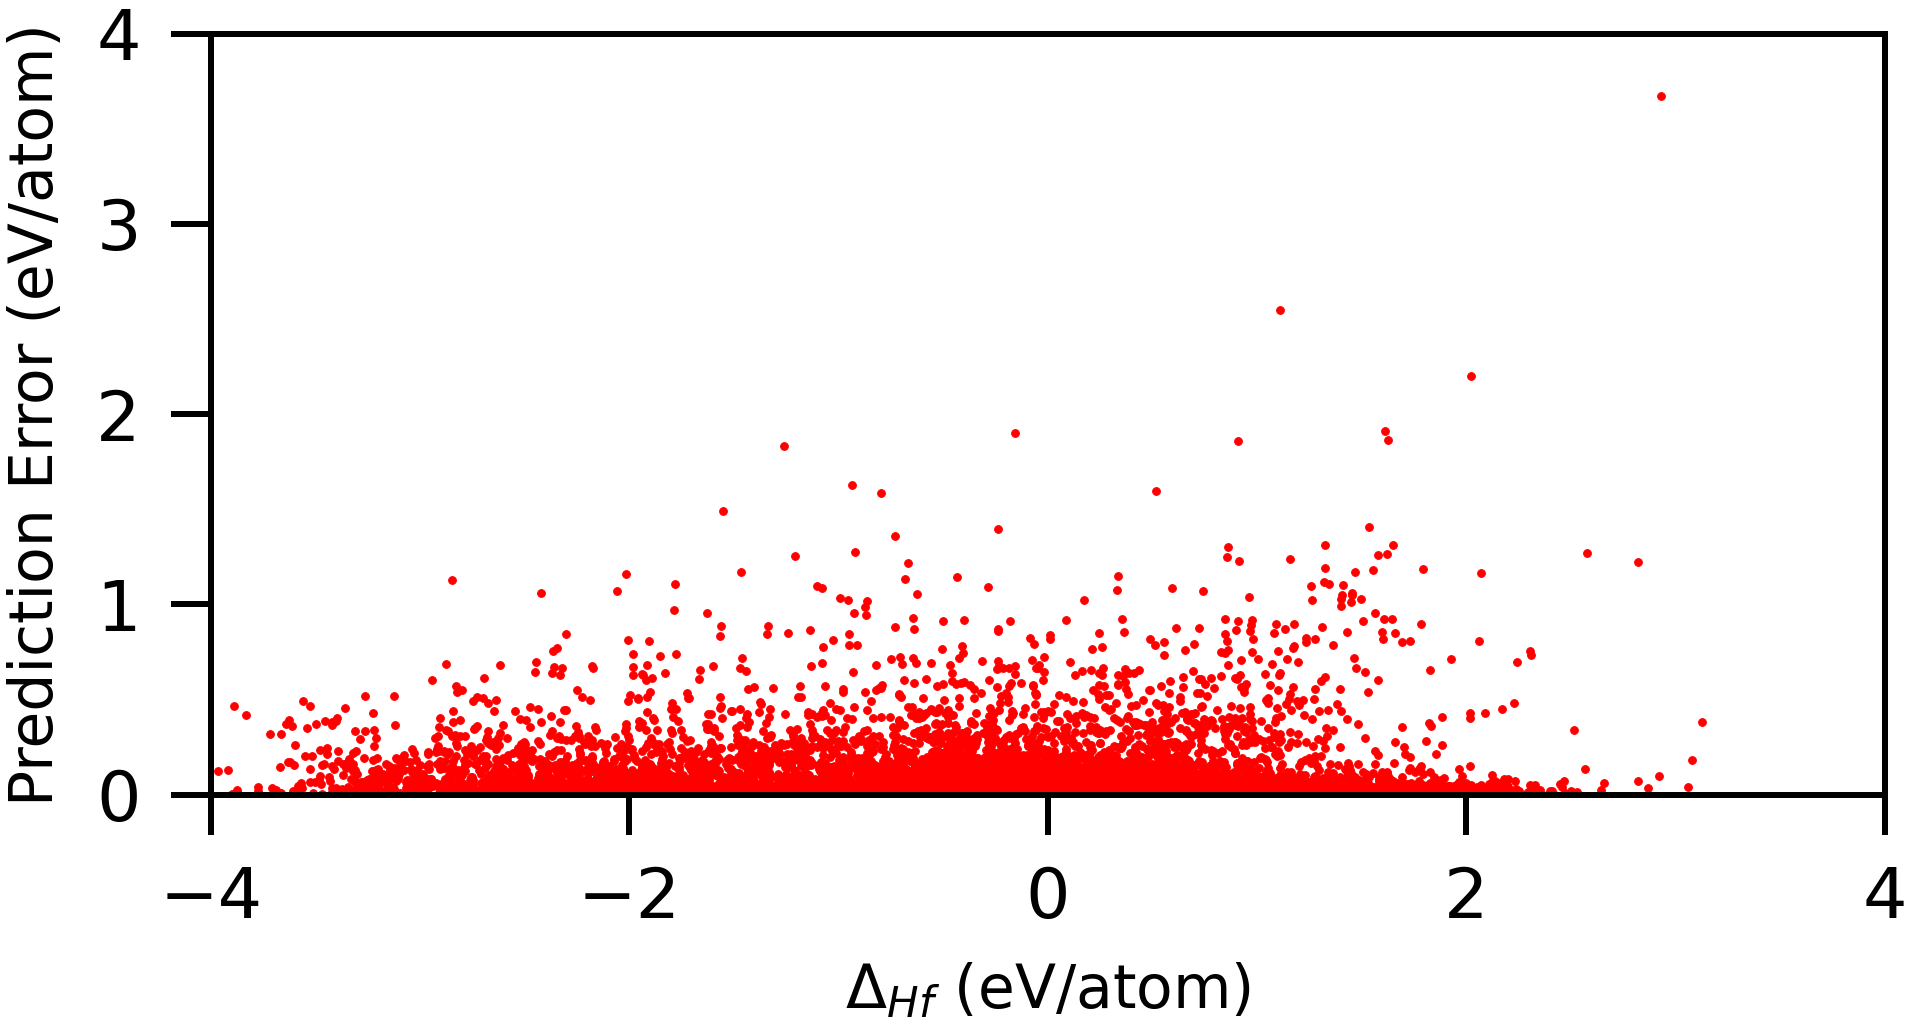

In [15]:
plt.figure(figsize=(30,14))
idx = error_deltae <= delta_e_mae
x_min = y_test[:,0][idx].min()
x_max = y_test[:,0][idx].max()
idx = np.logical_and(y_test[:,0] >= x_min, y_test[:,0] <= x_max) 
y_max = error_deltae[idx].max()
plt.scatter(y_test[:,0], error_deltae, c='r', s=60)
plt.xlabel(r'$\Delta_{Hf}$ (eV/atom)')
plt.ylabel(r'Prediction Error (eV/atom)')
plt.xlim(np.floor(x_min), np.ceil(x_max))
plt.ylim(0,np.ceil(y_max))
print(x_min)
print(x_max)
print(error_deltae[idx].mean())

7.0593699999999995
75.8358
0.39712808668318905


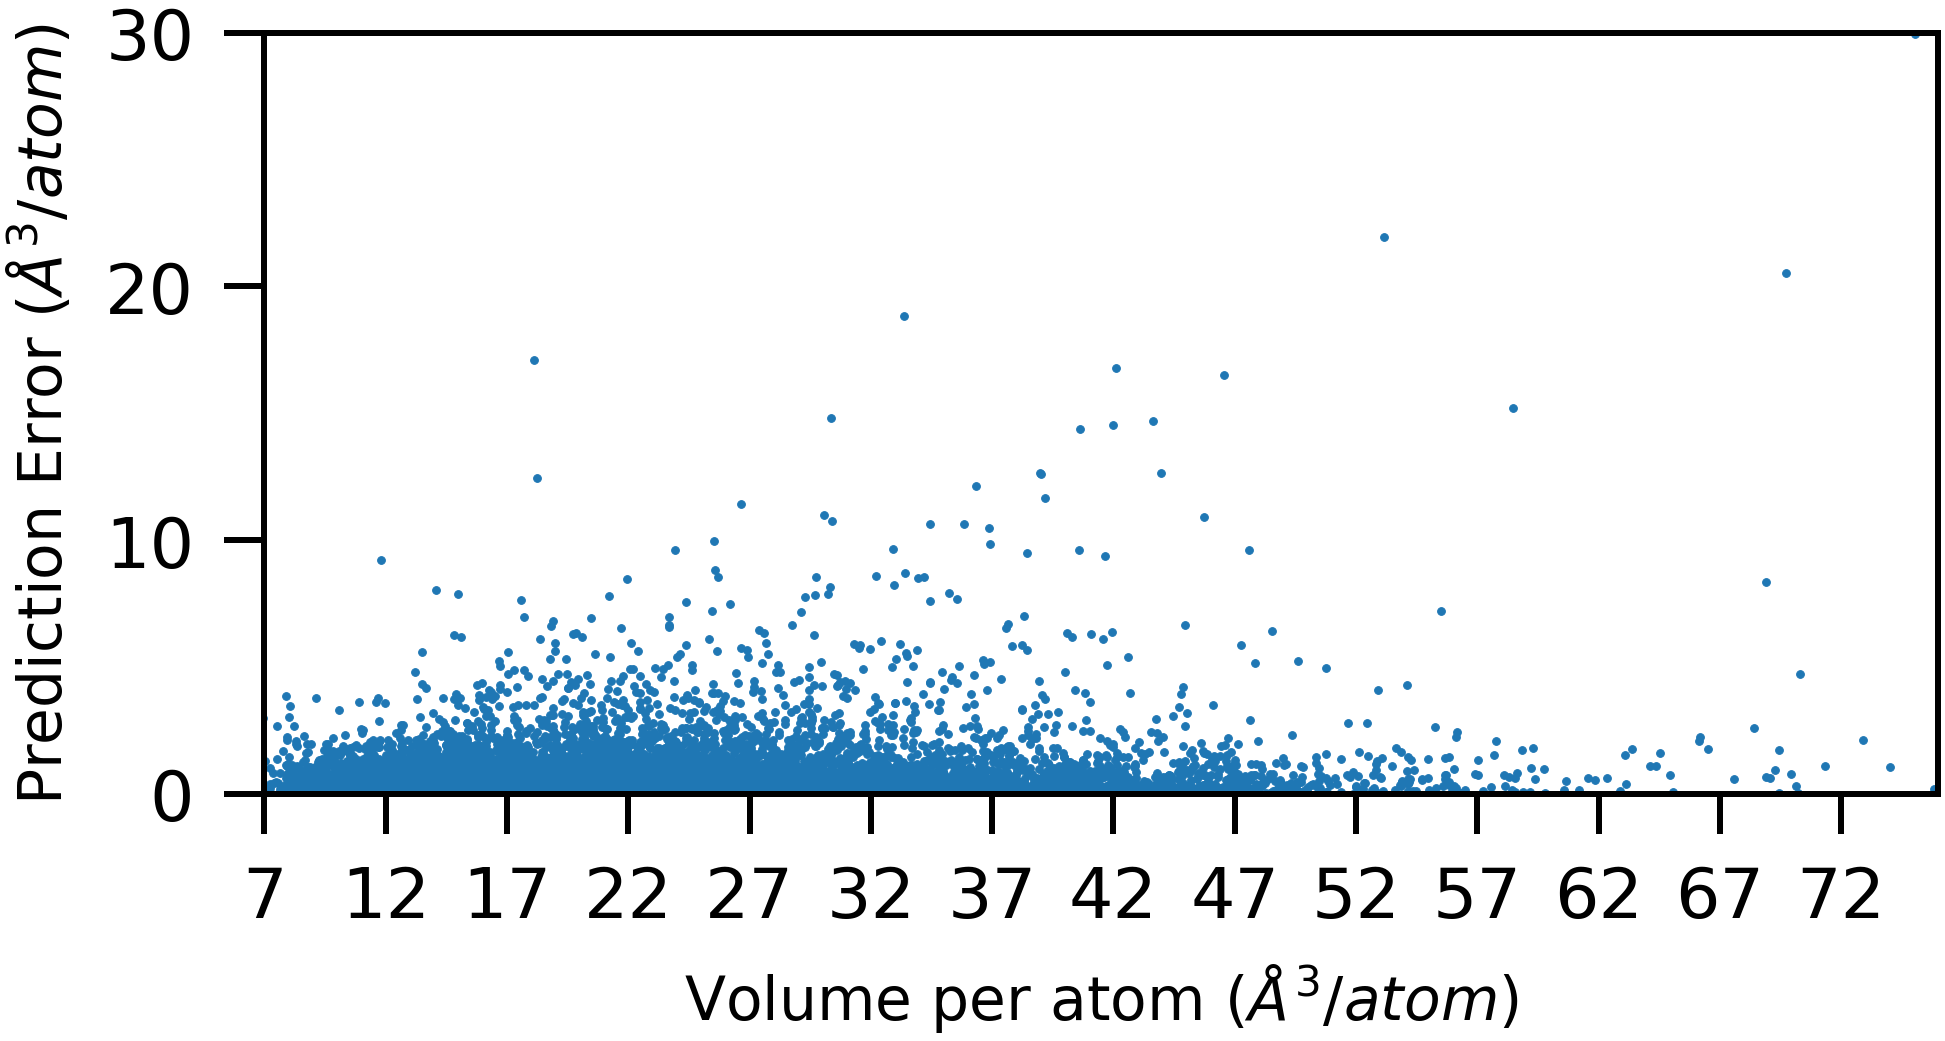

In [10]:
fig, ax = plt.subplots(1,1,figsize=(30,14))
idx = error_volume <= volume_pa_mae
x_min = y_test[:,1][idx].min()
x_max = y_test[:,1][idx].max()
idx = np.logical_and(y_test[:,1] >= x_min, y_test[:,1] <= x_max) 
y_max = error_volume[idx].max()
plt.scatter(y_test[:,1], error_volume, s=60)
plt.xlabel(r'Volume per atom $(\AA^3/atom)$')
plt.ylabel(r'Prediction Error $(\AA^3/atom)$')
plt.xlim(np.floor(x_min), np.ceil(x_max))
plt.ylim(0, np.ceil(y_max))
print(x_min)
print(x_max)
print(error_volume[idx].mean())
plt.xticks(range(int(np.floor(x_min)),int(np.ceil(x_max)) + 1, 5))
plt.show()

-12.784690625
-0.769756575
0.06919081544598463


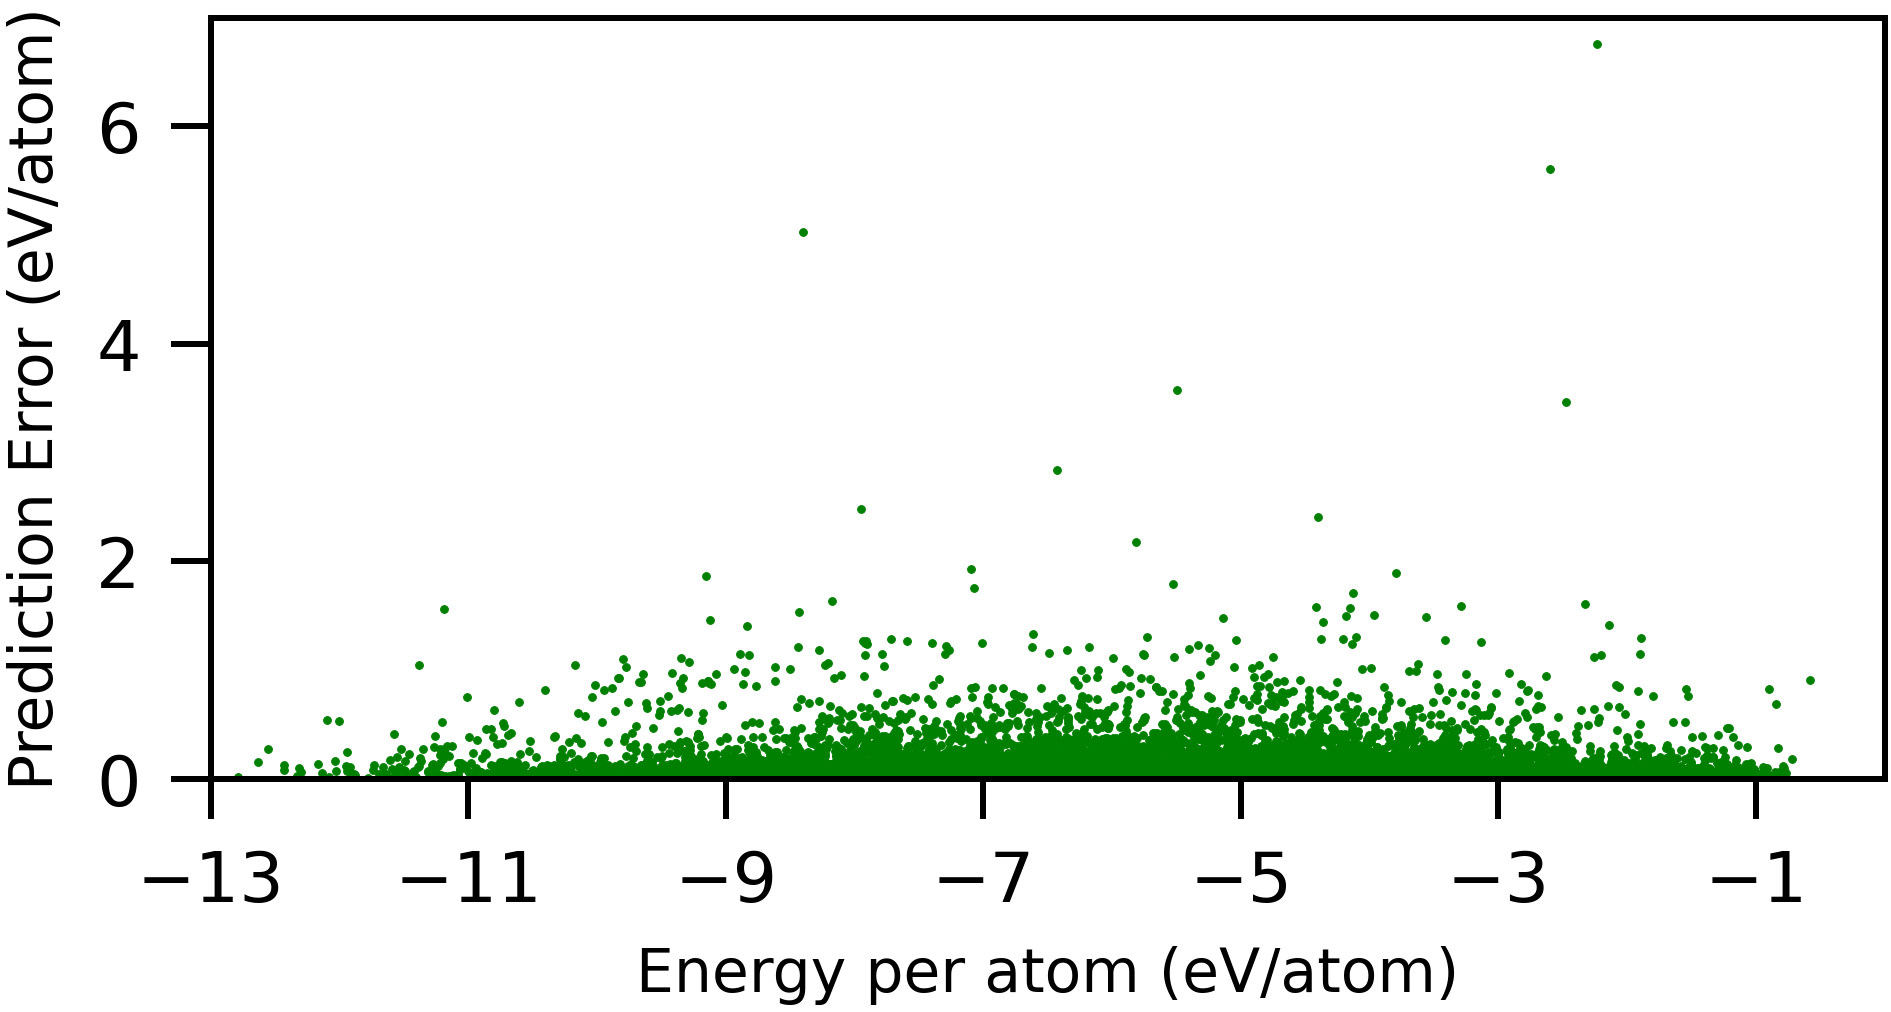

In [17]:
fig, ax = plt.subplots(1,1,figsize=(30,14))
idx = error_energy <= energy_pa_mae
x_min = y_test[:,2][idx].min()
x_max = y_test[:,2][idx].max()
idx = np.logical_and(y_test[:,2] >= x_min, y_test[:,2] <= x_max) 
y_max = error_energy[idx].max()
plt.scatter(y_test[:,2], error_energy, c='g', s=60)

plt.xlabel(r'Energy per atom (eV/atom)')
plt.ylabel(r'Prediction Error (eV/atom)')
plt.xlim(np.floor(x_min), np.ceil(x_max))
plt.ylim(0, np.ceil(y_max))
print(x_min)
print(x_max)
print(error_energy[idx].mean())
plt.xticks(range(int(np.floor(x_min)),int(np.ceil(x_max)) + 1,2))
plt.show()